In [1]:
import torch
from torch import nn
import timm
from timm.data import resolve_data_config, create_transform

from PIL import Image
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
device = "cuda:0" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")

# models

In [3]:
timm.list_models(["*dino*"], pretrained=True)

['resmlp_12_224.fb_dino',
 'resmlp_24_224.fb_dino',
 'vit_base_patch8_224.dino',
 'vit_base_patch14_dinov2.lvd142m',
 'vit_base_patch16_224.dino',
 'vit_giant_patch14_dinov2.lvd142m',
 'vit_large_patch14_dinov2.lvd142m',
 'vit_small_patch8_224.dino',
 'vit_small_patch14_dinov2.lvd142m',
 'vit_small_patch16_224.dino']

In [4]:
model = timm.create_model("vit_small_patch14_dinov2.lvd142m", pretrained=True, num_classes=0).to(device)
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identit

In [5]:
data_config = resolve_data_config({}, model=model)
data_config

{'input_size': (3, 518, 518),
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'crop_pct': 1.0,
 'crop_mode': 'center'}

In [6]:
transform = create_transform(**data_config)
transform

Compose(
    Resize(size=518, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(518, 518))
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

# images

In [7]:
image_dict = {}
for i in glob("*.jpg"):
    image_dict[i.split(".")[0]] = Image.open(i)
list(image_dict.keys())

['cat1',
 'cat2',
 'cat3',
 'cat4',
 'cat5',
 'dog1',
 'dog2',
 'dog3',
 'dog4',
 'dog5']

In [8]:
image_dict[list(image_dict.keys())[0]].size

(1280, 1280)

In [9]:
def preprocess(image_dict: dict) -> dict:
    procss_images = {}
    for k, v in image_dict.items():
        procss_images[k] = transform(v)
    return procss_images

In [10]:
procss_images = preprocess(image_dict)
procss_images[list(procss_images.keys())[0]].shape

torch.Size([3, 518, 518])

# run

In [11]:
with torch.inference_mode():
    extracts = model(torch.stack(list(procss_images.values()), dim=0).to(device))
extracts.shape

torch.Size([10, 384])

In [12]:
temp = extracts[:1]
temp.shape

torch.Size([1, 384])

In [13]:
# l2norm
temp.norm(p=2, dim=-1), temp.square().sum().sqrt()

(tensor([50.8455], device='cuda:0'), tensor(50.8455, device='cuda:0'))

In [14]:
# l1norm
temp.norm(p=1, dim=-1), temp.abs().sum()

(tensor([785.8330], device='cuda:0'), tensor(785.8330, device='cuda:0'))

# cosine similarity


[cosine similarity 详细介绍](../01_PyTorch基本/05数学运算/cosine%20similarity.ipynb)

In [15]:
cos_similarity_t = (extracts / extracts.norm(p=2, dim=1, keepdim=True)) @ (extracts / extracts.norm(p=2, dim=1, keepdim=True)).T
cos_similarity_t

tensor([[ 1.0000,  0.3165,  0.1117,  0.3242,  0.6451,  0.0607,  0.0701,  0.0447,
          0.0193,  0.0949],
        [ 0.3165,  1.0000,  0.4010,  0.6553,  0.2637,  0.0526,  0.1290,  0.0032,
          0.1126,  0.0542],
        [ 0.1117,  0.4010,  1.0000,  0.4814,  0.1214,  0.0091,  0.0222,  0.0996,
          0.0909,  0.1798],
        [ 0.3242,  0.6553,  0.4814,  1.0000,  0.1741,  0.0641,  0.1884,  0.0732,
          0.3465,  0.1239],
        [ 0.6451,  0.2637,  0.1214,  0.1741,  1.0000,  0.1034, -0.0164, -0.0213,
         -0.0085,  0.0738],
        [ 0.0607,  0.0526,  0.0091,  0.0641,  0.1034,  1.0000,  0.3706,  0.2094,
          0.0555,  0.1482],
        [ 0.0701,  0.1290,  0.0222,  0.1884, -0.0164,  0.3706,  1.0000,  0.0960,
          0.1385,  0.1710],
        [ 0.0447,  0.0032,  0.0996,  0.0732, -0.0213,  0.2094,  0.0960,  1.0000,
          0.1619,  0.3892],
        [ 0.0193,  0.1126,  0.0909,  0.3465, -0.0085,  0.0555,  0.1385,  0.1619,
          1.0000,  0.2790],
        [ 0.0949,  

In [16]:
cos_similarity = cos_similarity_t.cpu().detach().numpy()

In [17]:
names = list(procss_images.keys())
names

['cat1',
 'cat2',
 'cat3',
 'cat4',
 'cat5',
 'dog1',
 'dog2',
 'dog3',
 'dog4',
 'dog5']

In [18]:
figure = px.imshow(cos_similarity, text_auto=True, x=names, y=names, width=800, height=800, title="cat, dog cos similarity")
figure.show()

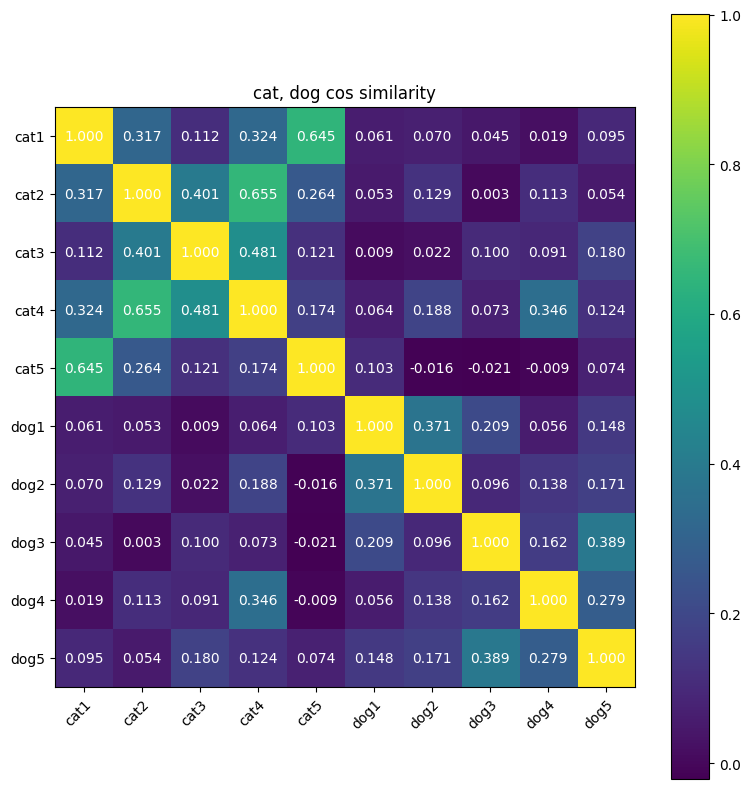

In [19]:
plt.figure(figsize=(8, 8))
plt.xticks(np.arange(len(names)), labels=names, rotation=45, rotation_mode="anchor", ha="right")
plt.yticks(np.arange(len(names)), labels=names)
plt.title("cat, dog cos similarity")

# 绘图
plt.imshow(cos_similarity)

# 添加文字
for i in range(len(names)):
    for j in range(len(names)):
        text = plt.text(j, i, "{:.3f}".format(cos_similarity[i, j]), ha="center", va="center", color="w")

plt.colorbar()      # 右侧的条
plt.tight_layout()
plt.show()